In [1]:
# Importing libraries
import sys
sys.path.insert(0,
                '/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Tau_pipeline/Tau_classification/')

from base import *
from constants import *

In [2]:
sys.path.insert(0,
                '/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Tau_pipeline/Tuning_parameters/')

from tuning import * 
from extra_metrics_training import *
from tuning_constants import *

In [3]:
import pandas as pd
import numpy as np 
import random 

from sklearn import preprocessing 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import scipy.stats as st 



In [4]:
import joblib

In [5]:
path = "/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Tau_pipeline/Tau_classification/Untrained/Training_data/STR/"
filename = "training.txt"

# Create tau database object 
str_data = TauDataBase(path = path,
                       filename = filename) 

# Prepping data to train tau classifier for striatum
str_data.classifier2_prep()

# Check data
print(str_data.c2_data['Class'].value_counts())
print(str_data.c2_X_train.shape)

Others    3116
CB         335
TA         200
NFT         48
Name: Class, dtype: int64
(3699, 54)


In [6]:
total_ = [] 
mean_total = []
all_ = [] 


sampling = list(range(10,110,10)) # 10% each time 
for i in sampling: 
    
    # Randomly picking out cells at 10% increment each time
    to_sample_from = str_data.c2_data.copy() 
    dat_sampled= to_sample_from.groupby('Class',group_keys=False).apply(lambda x: x.sample(frac=(i/100),random_state=42))
    print('sampling: ', i, '%')
    X_train = dat_sampled.drop(columns=['Class','Image','Centroid_X','Centroid_Y'])
    y_train = dat_sampled['Class']


    # 3) Specify parameters for grid search 
    rf_random = RandomizedSearchCV(pipeline,
                               param_distributions=random_grid, 
                               n_iter=100,
                               cv=10,
                               verbose=2,
                               random_state=42,
                               n_jobs=-1,
                               refit='PR_AUC',
                               scoring={
                                'PR_AUC':precision_recall_auc_tau,
                                'roc_auc_ovr_weighted':'roc_auc_ovr_weighted',
                                'roc_auc_ovo':'roc_auc_ovo',
                                'balanced_accuracy':'balanced_accuracy',
                                'f1_weighted':'f1_weighted',
                                'CB_accuracy': CB_acc,
                                'NFT_accuracy':NFT_acc,
                                'Others_accuracy':Others_acc,
                                'TA_accuracy':TA_acc
                                        },
                                  return_train_score=True)

    # 4) Run grid search 
    rf_random.fit(X_train,
                  y_train)

    ## Appending data together 
    accuracies_10_fold = [] 
    for i in range(0,10): 
        x = rf_random.cv_results_['split'+str(i)+'_test_PR_AUC'][rf_random.best_index_]
        accuracies_10_fold.append(x)

    total_.append(accuracies_10_fold)
    mean_total.append(mean(accuracies_10_fold))
    all_.append(rf_random) 

sampling:  10 %
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


c:\Users\mokur\anaconda3\envs\tau-pl-old\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
c:\Users\mokur\anaconda3\envs\tau-pl-old\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\mokur\anaconda3\envs\tau-pl-old\lib\site-packages\sklearn\model_selection\_search.py:931: RuntimeWarning: invalid value encountered in cast
  results["r

sampling:  20 %
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
sampling:  30 %
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
sampling:  40 %
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
sampling:  50 %
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
sampling:  60 %
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
sampling:  70 %
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
sampling:  80 %
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
sampling:  90 %
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
sampling:  100 %
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [7]:
### Saving outputs
joblib.dump(total_,"str_total.sav")
joblib.dump(mean_total,"str_mean_total.sav")
joblib.dump(all_,"str_all.sav")

['str_all.sav']

**Loading**

In [6]:
total_ = joblib.load('C:/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Tau_pipeline/Sample_size_check/STR/str_total.sav')
mean_total = joblib.load('C:/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Tau_pipeline/Sample_size_check/STR/str_mean_total.sav')
all_ = joblib.load('C:/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Tau_pipeline/Sample_size_check/STR/str_all.sav')

In [7]:
sampling = list(range(10,110,10))

In [8]:
data = str_data.c2_data

### Inspecting outputs

In [9]:
#Extract best params per sampling point (from 20% to 100%, 20% step)
best_params = []
best_scores = []
for i in range(0,10):
    best_params.append(all_[i].best_params_)
    best_scores.append(all_[i].best_score_)
print(best_scores)

[nan, 0.9368022988158042, 0.9627210826244216, 0.957326995476719, 0.9638251790072948, 0.9679054547327619, 0.962653699754409, 0.9690470645072866, 0.9701771108971728, 0.9713079172768145]


In [10]:
folder_path = "C:/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Tau_pipeline/Sample_size_check/STR/"

Fit times

In [11]:
## get fit times (mean & sd)
m_fit_times = []
std_fit_times= [] 
for i in range(0,10):
    m_fit_times.append(all_[i].cv_results_['mean_fit_time'])
    std_fit_times.append(all_[i].cv_results_['std_fit_time'])

In [12]:
## Calculate confidence interval: fit times 

mean_m_fit_times = [np.mean(i) for i in m_fit_times]

fit_total_CI = [st.t.interval(confidence=0.95, df=len(i)-1,
                                      loc=np.mean(i), scale=st.sem(i)) for i in m_fit_times]
fit_lower_ci = [i[0] for i in fit_total_CI]
fit_upper_ci = [i[1] for i in fit_total_CI]
cells = [int(i/100*data.shape[0]) for i in sampling]
fit_times_rbf = pd.DataFrame({'mean':mean_m_fit_times,
                           'lower_ci':fit_lower_ci,
                            'upper_ci':fit_upper_ci,
                           'cells':cells})

In [13]:
fit_times_rbf

,mean,lower_ci,upper_ci,cells
0,6.086101,5.637186,6.535017,369
1,7.513452,6.961705,8.065198,739
2,9.311510,8.617454,10.005567,1109
3,11.175034,10.332224,12.017844,1479
4,12.728095,11.770842,13.685348,1849
5,14.596513,13.494035,15.698990,2219
6,16.269660,15.021725,17.517595,2589
7,17.936127,16.567828,19.304427,2959
8,19.252027,17.763507,20.740547,3329
9,21.136206,19.507342,22.765071,3699


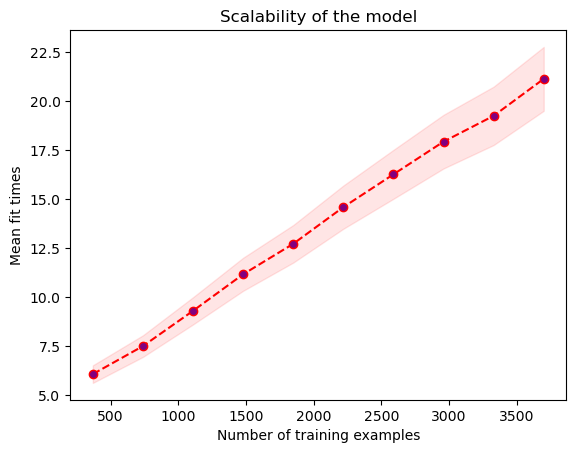

In [14]:
fig, ax=plt.subplots()

ax.plot(fit_times_rbf['cells'],fit_times_rbf['mean'],marker='o',markerfacecolor='purple',linestyle='dashed',color='red')
ax.fill_between(fit_times_rbf['cells'],fit_times_rbf['lower_ci'],fit_times_rbf['upper_ci'],color='red',alpha=.1)


plt.xlabel('Number of training examples')
plt.ylabel('Mean fit times')
plt.title('Scalability of the model')

path = folder_path+"fittimes_curve.jpg"
plt.savefig(path)

Balanced accuracy

In [15]:
samp_test_acc = [] 
samp_train_acc = []
for i in range(0,10):  
    test_acc=[]
    train_acc=[]
    for r in range(0,10):
        test_acc.append(all_[i].cv_results_['split'+str(r)+'_test_balanced_accuracy'][all_[i].best_index_])
        train_acc.append(all_[i].cv_results_['split'+str(r)+'_train_balanced_accuracy'][all_[i].best_index_])
    samp_test_acc.append(test_acc)
    samp_train_acc.append(train_acc)
    

In [16]:
# Rbf-SVM: Validation - calculate confidence interval (training balanced accuracy)

v_scaled_mean = [np.mean(i) for i in samp_train_acc]

v_total_CI = [st.t.interval(confidence=0.95,
                            df=len(i)-1,
                            loc=np.mean(i),
                            scale=st.sem(i)) for i in samp_train_acc]
v_lower_ci = [i[0] for i in v_total_CI]
v_upper_ci = [i[1] for i in v_total_CI]
cells = [int(i/100*data.shape[0]) for i in sampling]
train_rbf = pd.DataFrame({'mean':v_scaled_mean,
                           'lower_ci':v_lower_ci,
                            'upper_ci':v_upper_ci,
                           'cells':cells})

In [17]:
train_rbf

,mean,lower_ci,upper_ci,cells
0,0.942676,0.931011,0.954341,369
1,0.756648,0.750321,0.762975,739
2,0.833519,0.824121,0.842916,1109
3,0.856550,0.851082,0.862018,1479
4,0.858558,0.854051,0.863065,1849
5,0.871772,0.868049,0.875496,2219
6,0.868469,0.864173,0.872766,2589
7,0.919891,0.917353,0.922429,2959
8,0.899653,0.897170,0.902136,3329
9,0.902320,0.899465,0.905175,3699


In [18]:
# Rbf-SVM: Validation - calculate confidence interval 

v_scaled_mean = [np.mean(i) for i in samp_test_acc]

v_total_CI = [st.t.interval(confidence=0.95,
                            df=len(i)-1,
                            loc=np.mean(i),
                            scale=st.sem(i)) for i in samp_test_acc]
v_lower_ci = [i[0] for i in v_total_CI]
v_upper_ci = [i[1] for i in v_total_CI]
cells = [int(i/100*data.shape[0]) for i in sampling]
validation_rbf = pd.DataFrame({'mean':v_scaled_mean,
                           'lower_ci':v_lower_ci,
                            'upper_ci':v_upper_ci,
                           'cells':cells})

In [19]:
validation_rbf

,mean,lower_ci,upper_ci,cells
0,NaN,NaN,NaN,369
1,0.752759,0.708860,0.796657,739
2,0.786428,0.732334,0.840521,1109
3,0.818099,0.769324,0.866874,1479
4,0.817222,0.765722,0.868722,1849
5,0.840909,0.793988,0.887831,2219
6,0.853267,0.806454,0.900081,2589
7,0.899606,0.855400,0.943812,2959
8,0.861123,0.811530,0.910717,3329
9,0.874618,0.836354,0.912883,3699


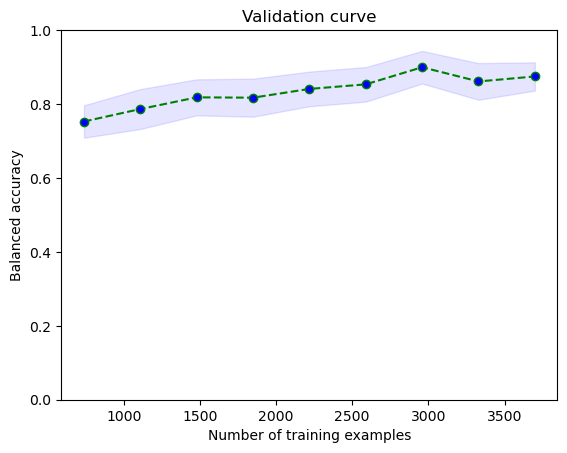

In [20]:
fig, ax=plt.subplots()
ax.plot(validation_rbf['cells'],validation_rbf['mean'],marker='o',markerfacecolor='blue',linestyle='dashed',color='green')
ax.fill_between(validation_rbf['cells'],validation_rbf['lower_ci'],validation_rbf['upper_ci'],color='b',alpha=.1)

plt.xlabel('Number of training examples')
plt.ylabel('Balanced accuracy')
plt.title('Validation curve')
plt.ylim([0,1])

path = folder_path+"validation_curve_BA.jpg"
plt.savefig(path)

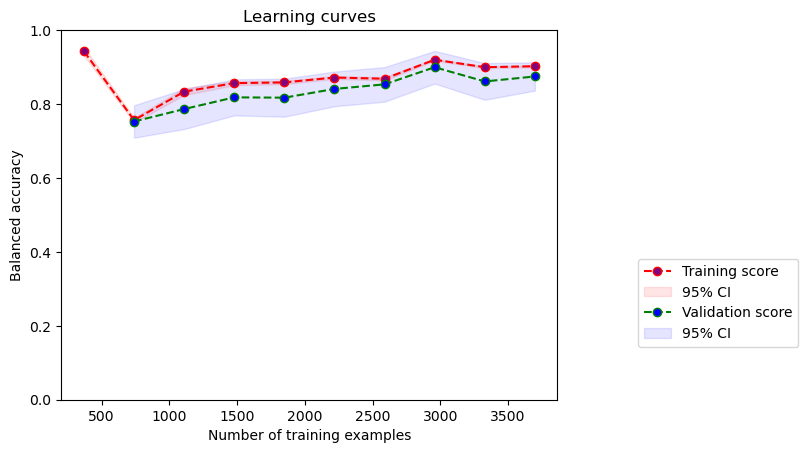

In [21]:
fig, ax=plt.subplots()

ax.plot(train_rbf['cells'],train_rbf['mean'],marker='o',markerfacecolor='purple',linestyle='dashed',color='red')
ax.fill_between(train_rbf['cells'],train_rbf['lower_ci'],train_rbf['upper_ci'],color='red',alpha=.1)

ax.plot(validation_rbf['cells'],validation_rbf['mean'],marker='o',markerfacecolor='blue',linestyle='dashed',color='green')
ax.fill_between(validation_rbf['cells'],validation_rbf['lower_ci'],validation_rbf['upper_ci'],color='b',alpha=.1)

plt.xlabel('Number of training examples')
plt.ylabel('Balanced accuracy')
plt.title('Learning curves')
plt.legend(["Training score","95% CI","Validation score","95% CI"],bbox_to_anchor=(1.5,0.4))
plt.ylim([0,1])

path = folder_path + "learning_curves_BA.jpg"
plt.savefig(path)

PR AUC

In [22]:
## Get train accuracies 
total_train =[] 
for s in range(0,10): # looping through sampling points 
    samp = all_[s]
    train_accuracies = [] 
    for i in range(0,10): # looping through 10 folds
        t = samp.cv_results_['split'+str(i)+'_train_PR_AUC'][samp.best_index_]
        train_accuracies.append(t)
    total_train.append(train_accuracies)
        

In [23]:
## Training - calculate confidence interval 
t_scaled_mean = [np.mean(i) for i in total_train]

t_total_CI = [st.t.interval(confidence=0.95, df=len(i)-1, loc=np.mean(i), scale=st.sem(i)) for i in total_train]

t_lower_ci = [i[0] for i in t_total_CI]
t_upper_ci = [i[1] for i in t_total_CI]
cells = [int(i/100*data.shape[0]) for i in sampling]
train_rbf_PR = pd.DataFrame({'mean':t_scaled_mean,
                           'lower_ci':t_lower_ci,
                            'upper_ci':t_upper_ci,
                           'cells':cells})

In [24]:
train_rbf_PR

,mean,lower_ci,upper_ci,cells
0,0.935250,0.927578,0.942922,369
1,0.957498,0.954816,0.960180,739
2,0.991603,0.990613,0.992592,1109
3,0.988779,0.988248,0.989309,1479
4,0.992125,0.991437,0.992812,1849
5,0.994100,0.993361,0.994838,2219
6,0.975049,0.973893,0.976206,2589
7,0.984831,0.984395,0.985266,2959
8,0.991802,0.991353,0.992251,3329
9,0.991233,0.990822,0.991644,3699


In [25]:
# Rbf-SVM: Validation - calculate confidence interval 

v_scaled_total = [] 
for t in total_: 
    s=[]
    for i in t: 
        i_=i 
        s.append(i_)
    v_scaled_total.append(s) 
    
v_scaled_mean = [np.mean(i) for i in v_scaled_total]

v_total_CI = [st.t.interval(confidence=0.95,
                            df=len(i)-1,
                            loc=np.mean(i),
                            scale=st.sem(i)) for i in v_scaled_total]
v_lower_ci = [i[0] for i in v_total_CI]
v_upper_ci = [i[1] for i in v_total_CI]
cells = [int(i/100*data.shape[0]) for i in sampling]
validation_rbf_PR = pd.DataFrame({'mean':v_scaled_mean,
                           'lower_ci':v_lower_ci,
                            'upper_ci':v_upper_ci,
                           'cells':cells})

In [26]:
validation_rbf_PR

,mean,lower_ci,upper_ci,cells
0,NaN,NaN,NaN,369
1,0.936802,0.916508,0.957097,739
2,0.962721,0.933886,0.991556,1109
3,0.957327,0.933443,0.981211,1479
4,0.963825,0.938667,0.988984,1849
5,0.967905,0.944620,0.991191,2219
6,0.962654,0.934925,0.990383,2589
7,0.969047,0.950284,0.987810,2959
8,0.970177,0.953876,0.986479,3329
9,0.971308,0.957121,0.985494,3699


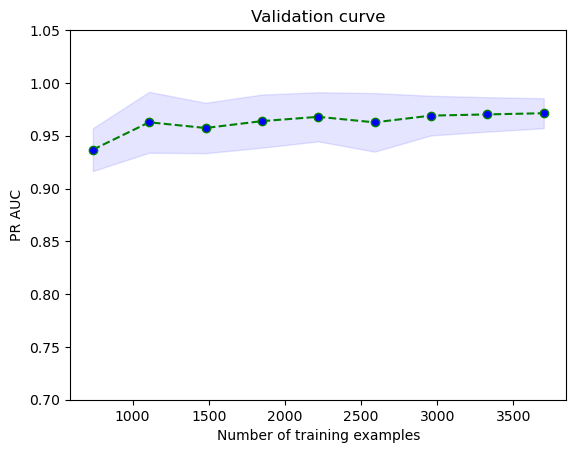

In [27]:
fig, ax=plt.subplots()
ax.plot(validation_rbf_PR['cells'],
        validation_rbf_PR['mean'],
        marker='o',markerfacecolor='blue',linestyle='dashed',color='green')
ax.fill_between(validation_rbf_PR['cells'],
                validation_rbf_PR['lower_ci'],
                validation_rbf_PR['upper_ci'],
                color='b',alpha=.1)

plt.xlabel('Number of training examples')
plt.ylabel('PR AUC')
plt.title('Validation curve')
plt.ylim([0.7,1.05])
path = folder_path + "validation_curve_PRAUC.jpg"
plt.savefig(path)

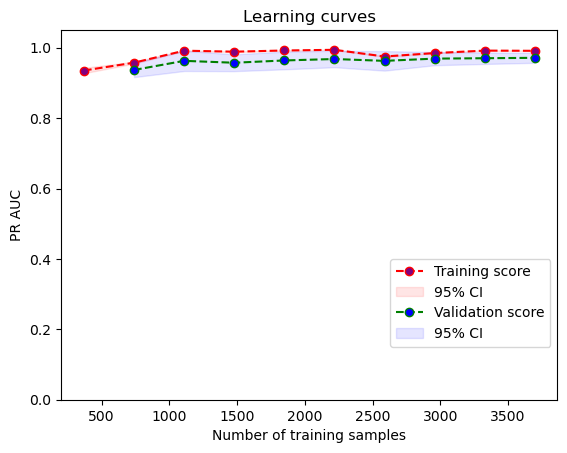

In [28]:
fig, ax=plt.subplots()

ax.plot(train_rbf_PR['cells'],
        train_rbf_PR['mean'],
        marker='o',markerfacecolor='purple',linestyle='dashed',color='red')
ax.fill_between(train_rbf_PR['cells'],
                train_rbf_PR['lower_ci'],
                train_rbf_PR['upper_ci'],
                color='red',alpha=.1)

ax.plot(validation_rbf_PR['cells'],
        validation_rbf_PR['mean'],
        marker='o',markerfacecolor='blue',linestyle='dashed',color='green')
ax.fill_between(validation_rbf_PR['cells'],
                validation_rbf_PR['lower_ci'],
                validation_rbf_PR['upper_ci'],
                color='b',alpha=.1)

plt.xlabel('Number of training samples')
plt.ylabel('PR AUC')
plt.title('Learning curves')
plt.legend(["Training score","95% CI","Validation score","95% CI"],bbox_to_anchor=(1,0.4))
plt.ylim([0,1.05])

path = folder_path + "learning_curves_PRAUC.jpg"
plt.savefig(path)